# びまん性肺疾患(4クラス, (train, validate, test))

## 前準備
### 主要パッケージを読み込む
loggerの設定も行う

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/LIDC_DLD')
CLASS_LABELS = ('normal', 'GGO', 'emphysema', 'honeycomb')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
import tut_utils
df_dataset = tut_utils.create_dataset_df(DATA_ROOT, CLASS_LABELS, IMAGE_EXT)
assert set(CLASS_LABELS) == set(df_dataset['class_label'].unique(
)), 'Discrepancy between CLASS_LABELS and df_dataset'
display(df_dataset)

,filepath,class_label,class
0,Data\Images\LIDC_DLD\normal\000.png,normal,0
1,Data\Images\LIDC_DLD\normal\001.png,normal,0
2,Data\Images\LIDC_DLD\normal\002.png,normal,0
3,Data\Images\LIDC_DLD\normal\003.png,normal,0
4,Data\Images\LIDC_DLD\normal\004.png,normal,0
...,...,...,...
843,Data\Images\LIDC_DLD\honeycomb\156.png,honeycomb,3
844,Data\Images\LIDC_DLD\honeycomb\157.png,honeycomb,3
845,Data\Images\LIDC_DLD\honeycomb\158.png,honeycomb,3
846,Data\Images\LIDC_DLD\honeycomb\159.png,honeycomb,3


### クラス毎の画像数を確認する。

In [4]:
df_dataset['class_label'].value_counts()

normal       294
GGO          203
emphysema    190
honeycomb    161
Name: class_label, dtype: int64

### 各クラスの画像を表示してみる

GGO


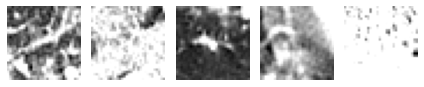

emphysema


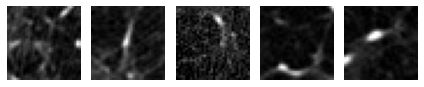

honeycomb


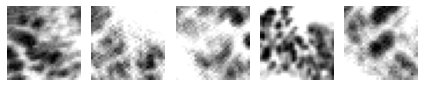

normal


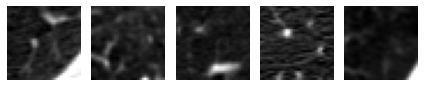

In [5]:
import tut_utils
tut_utils.show_images_each_class(df_dataset, n_rows=1)

### データ読み込み用の関数を作成

In [6]:
from PIL import Image
IMG_SHAPE = (1, 32, 32)


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)

## Data augmentation
いくつかの画像に対して実際にaugmentationを適用し表示する

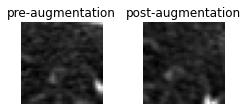

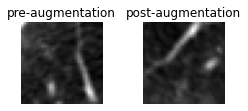

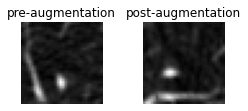

In [7]:
import torch
import albumentations as A
from tut_utils import AugmentedDataset, load_dataset

album_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=.1, contrast_limit=.1, p=.5),
    A.Flip(p=.5),
    A.ShiftScaleRotate(shift_limit=0.05,
                       scale_limit=.1,
                       rotate_limit=180,
                       p=.8)
])

N_TEST = 3


def random_transform(x, y):
    x = (x / 255).astype(np.float32)
    tfed = album_transform(image=x)
    x = tfed['image']
    x = x.transpose(2, 0, 1)  # to channels first
    return x.astype(np.float32), y


def base_transform(x, y):
    x = x / 255
    x = x.transpose(2, 0, 1)  # to channels first
    return x.astype(np.float32), y


def test_augmentation(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    train_data, train_labels = load_dataset(df_train, load_img)
    dataset = AugmentedDataset(train_data, train_labels, random_transform)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=0)
    for i, data in enumerate(loader):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(train_data[i], cmap='gray')
        plt.title('pre-augmentation')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(data[0].squeeze().numpy(), cmap='gray')
        plt.title('post-augmentation')
        plt.axis('off')
        plt.show()


test_augmentation(df_dataset)

## ネットワーク作成
画像が小さいのでこれまでより小さいネットワークを作成する。

In [8]:
import torch
import torch.nn as nn


class ConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_chs, out_chs, kernel_size=kernel_size),
            nn.BatchNorm2d(out_chs), nn.ReLU(inplace=True),
            nn.Conv2d(out_chs, out_chs, kernel_size=kernel_size),
            nn.BatchNorm2d(out_chs), nn.ReLU(inplace=True))

    def forward(self, x):
        return self.block(x)


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(ConvBlock(1, 8), nn.MaxPool2d(2),
                                     ConvBlock(8, 16), nn.MaxPool2d(2),
                                     nn.Dropout(.25), nn.Flatten(start_dim=1),
                                     nn.Linear(400, 32), nn.ReLU(inplace=True),
                                     nn.Linear(32, len(CLASS_LABELS)))

    def forward(self, x):
        return self.network(x)


from torchsummary import summary
summary(CNN(), IMG_SHAPE, verbose=False, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4]                   --
|    └─ConvBlock: 2-1                    [-1, 8, 28, 28]           --
|    |    └─Sequential: 3-1              [-1, 8, 28, 28]           696
|    └─MaxPool2d: 2-2                    [-1, 8, 14, 14]           --
|    └─ConvBlock: 2-3                    [-1, 16, 10, 10]          --
|    |    └─Sequential: 3-2              [-1, 16, 10, 10]          3,552
|    └─MaxPool2d: 2-4                    [-1, 16, 5, 5]            --
|    └─Dropout: 2-5                      [-1, 16, 5, 5]            --
|    └─Flatten: 2-6                      [-1, 400]                 --
|    └─Linear: 2-7                       [-1, 32]                  12,832
|    └─ReLU: 2-8                         [-1, 32]                  --
|    └─Linear: 2-9                       [-1, 4]                   132
Total params: 17,212
Trainable params: 17,212
Non-trainable params: 0
Total 

In [9]:
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
import os


class LitNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = CNN()

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## K-Fold 交差検証(train, validate, test)
各fold中でデータセットの$\frac{2}{4}$を学習用、$\frac{1}{4}$をvalidation(EarlyStopping)用、$\frac{1}{4}$を評価用に使用する

### DataFrameに交差検証用の列を追加する

In [10]:
import itertools
from sklearn.model_selection import StratifiedKFold

K_FOLD = 4
kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)

test_indices = [
    t[1] for t in kfold.split(df_dataset['filepath'], df_dataset['class'])
]
index2fold = dict(
    list(
        itertools.chain(*[[(idx, i) for idx in indices]
                          for i, indices in enumerate(test_indices)])))

df_dataset['set'] = df_dataset.index.map(index2fold)
df_dataset

,filepath,class_label,class,set
0,Data\Images\LIDC_DLD\normal\000.png,normal,0,3
1,Data\Images\LIDC_DLD\normal\001.png,normal,0,0
2,Data\Images\LIDC_DLD\normal\002.png,normal,0,3
3,Data\Images\LIDC_DLD\normal\003.png,normal,0,0
4,Data\Images\LIDC_DLD\normal\004.png,normal,0,2
...,...,...,...,...
843,Data\Images\LIDC_DLD\honeycomb\156.png,honeycomb,3,2
844,Data\Images\LIDC_DLD\honeycomb\157.png,honeycomb,3,0
845,Data\Images\LIDC_DLD\honeycomb\158.png,honeycomb,3,0
846,Data\Images\LIDC_DLD\honeycomb\159.png,honeycomb,3,1


### train, validate, testを用いた交差検証を行う

2021-03-31 14:10:42,323 INFO :1th iteration of 4-fold CV
GPU available: True, used: True
2021-03-31 14:10:42,479 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:10:42,480 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:10:42,481 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
2021-03-31 14:10:43,614 INFO :
  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-03-31 14:10:48,798 INFO :Finish training


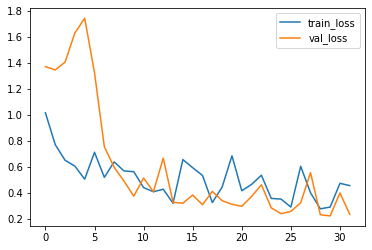

2021-03-31 14:10:48,988 INFO :2th iteration of 4-fold CV
GPU available: True, used: True
2021-03-31 14:10:49,173 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:10:49,174 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:10:49,175 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
2021-03-31 14:10:49,184 INFO :
  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-03-31 14:10:51,812 INFO :Finish training


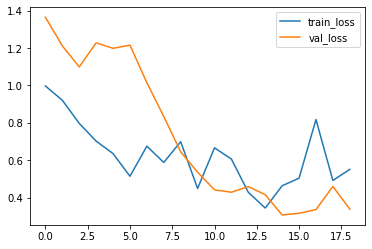

2021-03-31 14:10:51,975 INFO :3th iteration of 4-fold CV
GPU available: True, used: True
2021-03-31 14:10:52,158 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:10:52,159 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:10:52,160 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
2021-03-31 14:10:52,171 INFO :
  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-03-31 14:10:56,286 INFO :Finish training


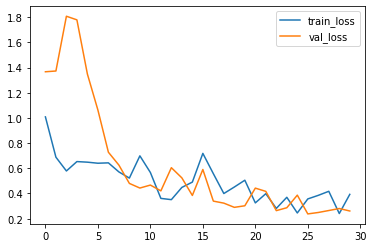

2021-03-31 14:10:56,461 INFO :4th iteration of 4-fold CV
GPU available: True, used: True
2021-03-31 14:10:56,631 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:10:56,632 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:10:56,634 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
2021-03-31 14:10:56,646 INFO :
  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 17.2 K
-------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-03-31 14:10:59,112 INFO :Finish training


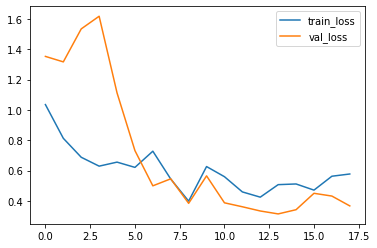

In [11]:
import copy
import tut_utils
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader

BATCH_SIZE = 64
EPOCHS = 32
PATIENCE = 4  # early stopping
NUM_WORKERS = 0 if os.name == 'nt' else 2
gpus = 1 if torch.cuda.is_available() else 0

results = []
for i_iter, test_fold in enumerate(range(K_FOLD)):
    logger.info('{i}th iteration of {k}-fold CV'.format(i=i_iter + 1,
                                                        k=K_FOLD))
    val_fold = (test_fold + 1) % K_FOLD
    train_folds = set(range(K_FOLD)) - set([test_fold]) - set([val_fold])
    df_train = df_dataset[df_dataset['set'].map(lambda e: e in train_folds)]
    df_val = df_dataset[df_dataset['set'] == val_fold]
    df_test = df_dataset[df_dataset['set'] == test_fold]
    (train_data,
     train_labels), (val_data, val_labels), (test_data, test_labels) = [
         load_dataset(df, load_img) for df in (df_train, df_val, df_test)
     ]
    trainloader = DataLoader(AugmentedDataset(train_data, train_labels,
                                              random_transform),
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)
    val_loader = DataLoader(AugmentedDataset(val_data, val_labels,
                                             base_transform),
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

    model = LitNet()
    early_stop_callback = EarlyStopping(monitor='val_loss',
                                        patience=PATIENCE,
                                        verbose=False,
                                        mode='min')
    csv_logger = CSVLogger('train_logs', name='dld')
    trainer = pl.Trainer(gpus=gpus,
                         max_epochs=EPOCHS,
                         logger=csv_logger,
                         log_every_n_steps=len(trainloader),
                         callbacks=[early_stop_callback])

    trainer.fit(model, trainloader, val_loader)
    logger.info('Finish training')
    df_logs = pd.read_csv(csv_logger.experiment.metrics_file_path)
    df_logs = pd.DataFrame(
        (df_logs['train_loss'].dropna().reset_index(drop=True),
         df_logs['val_loss'].dropna().reset_index(drop=True))).T
    df_logs.plot(y=['train_loss', 'val_loss'])
    plt.show()
    testloader = DataLoader(AugmentedDataset(test_data, test_labels,
                                             base_transform),
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

    df_result = tut_utils.predict_multiclass(model, testloader, df_test.index)
    results.append(df_result)

In [12]:
df_result = pd.concat(results, axis=0)
df_result = df_dataset.join(df_result)
display(df_result)

,filepath,class_label,class,set,pred_logits,pred_proba,pred_class
0,Data\Images\LIDC_DLD\normal\000.png,normal,0,3,"[3.4858482, -2.4970956, 4.026594, -5.4913263]","[0.36765584, 0.0009270048, 0.6313707, 4.641989...",2
1,Data\Images\LIDC_DLD\normal\001.png,normal,0,0,"[3.8116653, -2.8534532, 2.862907, -4.521449]","[0.72007895, 0.00091781694, 0.27883005, 0.0001...",0
2,Data\Images\LIDC_DLD\normal\002.png,normal,0,3,"[2.5964322, -1.9648861, 3.7196832, -4.2224164]","[0.24471565, 0.0025568563, 0.75246, 0.00026746...",2
3,Data\Images\LIDC_DLD\normal\003.png,normal,0,0,"[4.0602612, -2.8428252, 3.012776, -4.849481]","[0.7396676, 0.0007431288, 0.2594893, 9.9904406...",0
4,Data\Images\LIDC_DLD\normal\004.png,normal,0,2,"[3.910317, -1.9969523, 3.5417597, -4.351062]","[0.59007156, 0.0016047603, 0.40817118, 0.00015...",0
...,...,...,...,...,...,...,...
843,Data\Images\LIDC_DLD\honeycomb\156.png,honeycomb,3,2,"[-8.676516, 0.7659973, -4.2477202, 7.129397]","[1.3640388e-07, 0.0017205125, 1.1434782e-05, 0...",3
844,Data\Images\LIDC_DLD\honeycomb\157.png,honeycomb,3,0,"[-10.057521, 4.202267, -6.0410666, 7.5605464]","[2.1563336e-08, 0.033625055, 1.1968498e-06, 0....",3
845,Data\Images\LIDC_DLD\honeycomb\158.png,honeycomb,3,0,"[-10.295136, 2.3481545, -5.008422, 8.206767]","[9.193616e-09, 0.0028470682, 1.817512e-06, 0.9...",3
846,Data\Images\LIDC_DLD\honeycomb\159.png,honeycomb,3,1,"[-8.567117, 3.6462436, -5.744788, 3.98425]","[2.066279e-06, 0.41627848, 3.474647e-05, 0.583...",3


## 評価
### 混同行列

In [13]:
df_cm = tut_utils.confusion_matrix(df_result)
print('Accuracy = {n} / {d} = {a:.03g}%'.format(n=df_cm.values.trace(),
                                                d=df_cm.values.sum(),
                                                a=100 * df_cm.values.trace() /
                                                df_cm.values.sum()))

display(df_cm)

Accuracy = 751 / 848 = 88.6%


Prediction,normal,GGO,emphysema,honeycomb
Truth,,,,
normal,248,2,44,0
GGO,1,190,0,12
emphysema,16,3,170,1
honeycomb,0,18,0,143


### ROC

(4, 848)


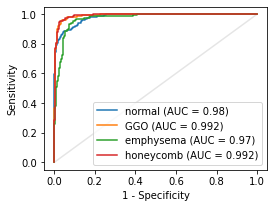

In [14]:
tut_utils.plot_roc_curves(df_result, figsize=(4, 3))
plt.show()

In [15]:
from sklearn import metrics
report = metrics.classification_report(df_result['class'],
                                       df_result['pred_class'],
                                       target_names=CLASS_LABELS,
                                       output_dict=True)
df_report = pd.DataFrame(report)
display(df_report.T)

,precision,recall,f1-score,support
normal,0.935849,0.843537,0.887299,294.000000
GGO,0.892019,0.935961,0.913462,203.000000
emphysema,0.794393,0.894737,0.841584,190.000000
honeycomb,0.916667,0.888199,0.902208,161.000000
accuracy,0.885613,0.885613,0.885613,0.885613
macro avg,0.884732,0.890608,0.886138,848.000000
weighted avg,0.890020,0.885613,0.886150,848.000000


### クラスごとに間違えている例を表示
#### 画像ごとにlossを計算

In [16]:
df_result['loss'] = F.cross_entropy(torch.FloatTensor(
    df_result['pred_logits']),
                                    torch.tensor(df_result['class']),
                                    reduction='none').numpy()
display(df_result)

,filepath,class_label,class,set,pred_logits,pred_proba,pred_class,loss
0,Data\Images\LIDC_DLD\normal\000.png,normal,0,3,"[3.4858482, -2.4970956, 4.026594, -5.4913263]","[0.36765584, 0.0009270048, 0.6313707, 4.641989...",2,1.000608
1,Data\Images\LIDC_DLD\normal\001.png,normal,0,0,"[3.8116653, -2.8534532, 2.862907, -4.521449]","[0.72007895, 0.00091781694, 0.27883005, 0.0001...",0,0.328394
2,Data\Images\LIDC_DLD\normal\002.png,normal,0,3,"[2.5964322, -1.9648861, 3.7196832, -4.2224164]","[0.24471565, 0.0025568563, 0.75246, 0.00026746...",2,1.407658
3,Data\Images\LIDC_DLD\normal\003.png,normal,0,0,"[4.0602612, -2.8428252, 3.012776, -4.849481]","[0.7396676, 0.0007431288, 0.2594893, 9.9904406...",0,0.301554
4,Data\Images\LIDC_DLD\normal\004.png,normal,0,2,"[3.910317, -1.9969523, 3.5417597, -4.351062]","[0.59007156, 0.0016047603, 0.40817118, 0.00015...",0,0.527511
...,...,...,...,...,...,...,...,...
843,Data\Images\LIDC_DLD\honeycomb\156.png,honeycomb,3,2,"[-8.676516, 0.7659973, -4.2477202, 7.129397]","[1.3640388e-07, 0.0017205125, 1.1434782e-05, 0...",3,0.001734
844,Data\Images\LIDC_DLD\honeycomb\157.png,honeycomb,3,0,"[-10.057521, 4.202267, -6.0410666, 7.5605464]","[2.1563336e-08, 0.033625055, 1.1968498e-06, 0....",3,0.034205
845,Data\Images\LIDC_DLD\honeycomb\158.png,honeycomb,3,0,"[-10.295136, 2.3481545, -5.008422, 8.206767]","[9.193616e-09, 0.0028470682, 1.817512e-06, 0.9...",3,0.002853
846,Data\Images\LIDC_DLD\honeycomb\159.png,honeycomb,3,1,"[-8.567117, 3.6462436, -5.744788, 3.98425]","[2.066279e-06, 0.41627848, 3.474647e-05, 0.583...",3,0.538394


#### lossの値が大きい画像を表示

GGO


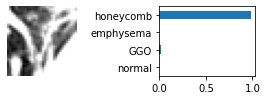

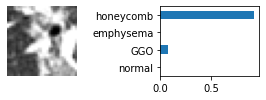

emphysema


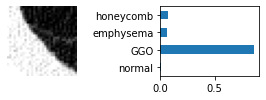

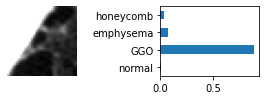

honeycomb


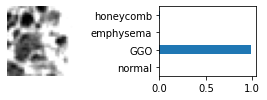

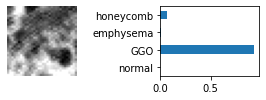

normal


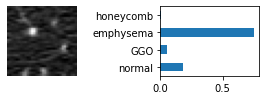

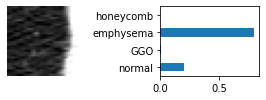

In [17]:
N_SAMPLES = 2
for class_label, group in df_result.groupby('class_label'):
    print(class_label)
    worst = group.sort_values('loss', ascending=False).head(N_SAMPLES)
    worst_data, worst_labels = load_dataset(worst, load_img)
    for img, pred_proba in zip(worst_data, worst['pred_proba']):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        ax = plt.subplot(1, 2, 2)
        pd.DataFrame(pred_proba, index=CLASS_LABELS).plot(ax=ax,
                                                          kind='barh',
                                                          legend=False)
        plt.tight_layout()
        plt.show()